For the sake of readibility, the algorithms are implemented in `code.py`, I give here the answers to the questions and display some results.

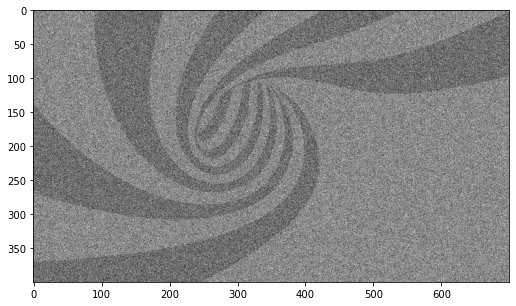

In [1]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import numpy as np

# Import the implemented algorithms
from code import IsingMessageGraph, IsingGibbsSampler, IsingEM, IsingGibbsSamplerParams

# Import the image and add noise
image = Image.open("spiral.png")
image = ImageOps.grayscale(image)
original = np.asarray(image) / 255
noisy = original + np.random.randn(*original.shape)

def show(array, figsize=(10,5)):
    plt.figure(figsize=figsize)
    plt.imshow(array, cmap=plt.cm.gray)
    plt.show()

show(noisy)

# Loopy Belief Propagation

Since there are loops in the undirected graph defined by our model, we cannot use directly belief propagation. Instead, we used what is called loopy belief propagation, where we pass messages between nodes like in belief propagation, iterate it and hope it converges at some point.

Unlike belief propagation for trees, we have no guarantee on the exactness or even on the convergence of the algorithm.

The joint distribution of $(x,y)$ reads as:

\begin{align*}
p(x,y) &= \frac 1{Z_{\alpha,\beta}} \exp\left(
\alpha \sum_{i=1}^n x_i + \beta \sum_{(i,j) \in E} \mathbb{1}_{x_i=x_j} 
\right)
\prod_{i=1}^n  \mathcal N(y_i;\mu_{x_i},1)\\
&\propto  \exp\left(
\alpha \sum_{i=1}^n x_i + \beta \sum_{(i,j) \in E} \mathbb{1}_{x_i=x_j} - \frac 12 \sum_{i=1}^n \left(y_i - \mu_{x_i}\right)^2
\right)
\end{align*}

We condition on the observed value of $y$, denoted by $\tilde y$, by multiplying this distribution by $\prod_{i=1}^n \mathbb{1}_{y_i = \tilde y_i}$.

Then we find the following expression of the messages between nodes:

\begin{align*}
\forall i \in \{1,\dots,n\} \quad \mu_{y_i \to x_i}(x_i) &= \exp\left(\alpha x_i\right) \mathcal N(\tilde y_i;\mu_{x_i},1) \\
\forall (i,j) \in E \quad \mu_{x_i \to x_j}(x_j) &= \sum_{x_i \in \{0,1\}} \exp(\beta \mathbb 1_{x_i = x_j}) \mu_{y_i \to x_i}(x_i) \prod_{k \neq j : (i,k) \in E} \mu_{x_k \to x_i}(x_i) \\
&= \exp(\beta) \mu_{y_i \to x_i}(x_j) \prod_{k \neq j : (i,k) \in E} \mu_{x_k \to x_i}(x_j) + \mu_{y_i \to x_i}(1 - x_j) \prod_{k \neq j : (i,k) \in E} \mu_{x_k \to x_i}(1 - x_j)
\end{align*}

After the messages have converged, we can compute the conditional marginal by multiplying the incoming messages:

$$p(x_i| y=\tilde y) = \mu_{y_i \to x_i}(x_i) \prod_{j : (i,j) \in E} \mu_{x_j \to x_i}(x_i)$$

Loopy belief propagation for this model is implemented by ``IsingMessageGraph``, with an example below:

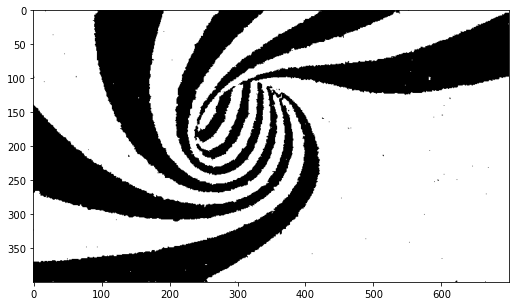

In [2]:
LBP = IsingMessageGraph(
    y=noisy,
    alpha=0.01,
    beta=1,
    mu=[0, 1]
)

np.random.seed(0)
LBP.message_passing(num_iter=10)
show(LBP.locally_most_probable())

# MCMC

We can use Gibbs sampling to sample from $p(x|y)$. We sample recursively, for $t \in \{1,\dots,T\}$:

$$x_1 \sim p(x_1|x_{-1}, y) \\
\vdots \\
x_n \sim p(x_n|x_{-n}, y)$$

This defines a MCMC with invariant distribution $p(x|y)$. Using the undirected graph structure, we can sample from $p(x_i | x_{-i}, y)$ using only the current samples in the neighbours of $x_i$ (its Markov blanket). That is:

$$p(x_i | x_{-i}, y) \propto \exp\left(
    \alpha x_i + \beta \sum_{j : (i,j) \in E} \mathbb{1}_{x_i = x_j} - \frac 12 \left(y_i - \mu_{x_i}\right)^2
\right)$$

Hence, $x_i | x_{-i}, y \sim \mathcal B(p)$, where:

\begin{align*}
p &= \frac
{1}
{1
+
\exp\left(
    - \alpha + \beta \sum_{j : (i,j) \in E} \left(\mathbb{1}_{x_j = 0} - \mathbb{1}_{x_j = 1}\right) - \frac 12 \left(y_i - \mu_0\right)^2 + \frac 12 \left(y_i - \mu_1\right)^2
\right)}\\
&= \frac
{1}
{1
+
\exp\left(
    - \alpha + \beta \sum_{j : (i,j) \in E} \left(\mathbb{1}_{x_j = 0} - \mathbb{1}_{x_j = 1}\right) + y_i (\mu_0 - \mu_1) + \frac 12 (\mu_0^2 + \mu_1^2)
\right)}\\
\end{align*}

Thus we just need to sample from Bernoulli distributions, which is easily done by comparing a sample from a uniform distribution to the parameter of the Bernoulli distribution.

Gibbs sampling is implemented by ``IsingGibbsSampler``, with an example below:

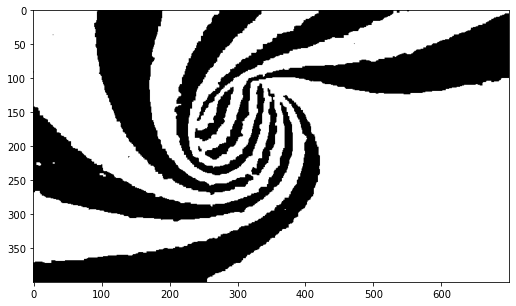

In [8]:
MCMC = IsingGibbsSampler(
    y=noisy,
    alpha=0.1,
    beta=100,
    mu=[0, 1]
)

np.random.seed(0)
sample = MCMC.gibbs_sampling(T=15, trajectory=False)
show(sample)

# EM

In the update of EM algorithm at iteration $t$, we wish to maximise with respect to $\mu$ the expected complete data log-likelihood at $\mu^{t-1}$, that is to maximise the function:

\begin{align*}
E(\mu) &= \mathbb E_{x \sim p(x|y,\mu^{t-1})}\left(\log p(x, y | \mu)\right) \\
&= \mathbb E_{x \sim p(x|y,\mu^{t-1})}\left(
\alpha \sum_{i=1}^n x_i + \beta \sum_{(i,j) \in E} \mathbb{1}_{x_i=x_j} - \frac 12 \sum_{i=1}^n \left(y_i - \mu_{x_i}\right)^2 
\right)
+\log Z_{\alpha,\beta}- \frac n2 \log\left(2\pi\right)\\
&= - \frac 12 \mathbb E_{x \sim p(x|y,\mu^{t-1})}\left(
 \sum_{i=1}^n \mathbb 1_{x_i = 0} \left(y_i - \mu_0\right)^2 + \sum_{i=1}^n \mathbb 1_{x_i = 1} \left(y_i - \mu_1\right)^2
\right)  + cst \\
\nabla E(\mu) &= \begin{pmatrix}
\mathbb E_{x \sim p(x|y,\mu^{t-1})}\left( \sum_{i=1}^n \mathbb 1_{x_i = 0} \left(y_i - \mu_0\right) \right) \\
\mathbb E_{x \sim p(x|y,\mu^{t-1})}\left( \sum_{i=1}^n \mathbb 1_{x_i = 1} \left(y_i - \mu_1\right) \right)
\end{pmatrix}
\end{align*}
 
Where $cst$ is a constant independent of $\mu$, and where we differentiated under the expectation sign thanks to the gradient of the integrand being bounded with respect to $x$. At line Hence the maximiser is:

$$\mu^t = \begin{pmatrix}
\frac {\sum_{i=1}^n y_i p(x_i = 0 | y_i, \mu^{t-1})} {\sum_{i=1}^n p(x_i = 0 | y_i, \mu^{t-1})} \\
\frac {\sum_{i=1}^n y_i p(x_i = 1 | y_i, \mu^{t-1})} {\sum_{i=1}^n p(x_i = 1 | y_i, \mu^{t-1})}
\end{pmatrix}$$

In question 2, we found a way to sample $x$ according to $p(x|y, \mu)$. This allows to estimate $\mu^t$ by estimating the probabilities (as expectations of characteristic functions) thanks to a Monte Carlo method.

The EM algorithm is implemented by ``IsingEM``, with an example below:

In [4]:
EM = IsingEM(
    y=noisy,
    alpha=0.01,
    beta=1
)

np.random.seed(0)
mu = EM.estimation(num_iter=10, verbose=True, burn_samples=5, num_samples=10)

Initialisation: mu=[-0.09434800708184099, 1.4072694268497927]
Iteration 1: mu=[-0.016931090414202883, 1.1291663114436645]
Iteration 2: mu=[-0.025950733609855257, 1.054349414996859]
Iteration 3: mu=[-0.02918022695442802, 1.0407221149499237]
Iteration 4: mu=[-0.03381999536544395, 1.0360527797623609]
Iteration 5: mu=[-0.032899017488824074, 1.0363445929726247]
Iteration 6: mu=[-0.03326976788781352, 1.0357890870882371]
Iteration 7: mu=[-0.033321471835206694, 1.035858944490463]
Iteration 8: mu=[-0.03433534164485129, 1.0355665527251066]
Iteration 9: mu=[-0.032714369679906936, 1.0378209292817464]
Iteration 10: mu=[-0.03343883183227516, 1.0361991169173588]


# Estimating $\alpha$ and $\beta$

The problem that arises when trying to estimate $\alpha$ and $\beta$ with the EM algorithm is that they are present in the normalising constant $Z_{\alpha, \beta}$ of $p(x)$, which complexifies the EM update.

The family of joint distribution of $p(x,y|\mu, \alpha, \beta)$ is an exponential family:

\begin{align*}
p(x,y|\mu, \alpha, \beta) &= b(x,y) \exp \left( \theta^T s(x,y) - A(\theta) \right) \\
\theta &= (\mu_0,\mu_1,\mu_0^2,\mu_1^2,\alpha, \beta)^T \\
s(x,y) &= \begin{pmatrix}
\sum_{i=1}^n y_i \mathbb 1_{x_i = 0} \\
\sum_{i=1}^n y_i \mathbb 1_{x_i = 1} \\
-\frac 12 \sum_{i=1}^n \mathbb 1_{x_i = 0} \\
-\frac 12 \sum_{i=1}^n \mathbb 1_{x_i = 1} \\
\sum_{i=1}^n x_i \\
\sum_{(i,j) \in E} \mathbb{1}_{x_i=x_j}
\end{pmatrix} \\
b(x,y) &= \exp\left( - \frac n2 \log(2\pi) - \frac 12 \sum_{i=1}^n y_i^2 \right) \\
A(\theta) &= \log Z_{\alpha,\beta}
\end{align*}

Let us use the general update of the EM algorithm for exponential families, that is solving for $\theta$ the equation:

$$\mathbb E_{(X,Y) \sim p(x,y | \theta)}\left(s(X,Y)\right) = \mathbb E_{X \sim p(x | y, \theta^{t-1})}\left(s(X,y)\right)$$

For $\mu$ we recover the previous update at question 3 (up to replacing $\mu^{t-1}$ by $\theta^{t-1}$ in the probabilities). We are left with the equations for $\alpha$ and $\beta$:

\begin{align*}
\sum_{i=1}^n E_{X \sim p(x | \theta)}\left(X_i\right) &= \sum_{i=1}^n \mathbb E_{X \sim p(x | y, \theta^{t-1})}\left(X_i\right) \\
\sum_{(i,j) \in E} p\left(x_i = x_j | \theta\right) &= \sum_{(i,j) \in E} p\left(x_i = x_j | y, \theta^{t-1}\right) \\
\end{align*}

These expressions are hard to invert for $\alpha$ and $\beta$.

# Sampling the parameters

\begin{align*}
p(x,y,\alpha,\beta,\mu) &= \pi(\alpha,\beta,\mu)p(x|\alpha,\beta)p(y|x,\mu)\\
& \propto \frac 1{Z_{\alpha,\beta}} \exp\left(
\alpha \sum_{i=1}^n x_i + \beta \sum_{(i,j) \in E} \mathbb{1}_{x_i=x_j} - \frac 12 \sum_{i=1}^n  \left(y_i - \mu_{x_i}\right)^2
\right)
\varphi(\mu_0;m, s^2)
\varphi(\mu_1;m, s^2)
Z_{\alpha,\beta}
\mathbb 1_{[0,a]}(\alpha)
\mathbb 1_{[0,b]}(\beta)\\
& \propto \exp\left(
\alpha \sum_{i=1}^n x_i + \beta \sum_{(i,j) \in E} \mathbb{1}_{x_i=x_j} - \frac 12 \sum_{i=1}^n  \left(y_i - \mu_{x_i}\right)^2
\right)
\varphi(\mu_0;m, s^2)
\varphi(\mu_1;m, s^2)
\mathbb 1_{[0,a]}(\alpha)
\mathbb 1_{[0,b]}(\beta)
\end{align*}

The $x_i$ are sampled from the same distribution as earlier, and the parameters are sampled from:

\begin{align*}
p(\alpha | x) &\propto \exp\left(\alpha \sum_{i=1}^n x_i \right)
\mathbb 1_{[0,a]}(\alpha) \\
p(\beta | x) &\propto \exp\left(\beta \sum_{(i,j) \in E} \mathbb{1}_{x_i=x_j} \right)
\mathbb 1_{[0,b]}(\beta) \\
p(\mu_k | x, y) &\propto \exp\left(
- \frac 12 \sum_{i=1}^n \mathbb 1_{x_i = k} \left(y_i - \mu_k\right)^2
\right)
\varphi(\mu_k;m, s^2) \\
&= \varphi(\mu_k; \gamma_k, \sigma_k^2)\\
\end{align*}

Where:

\begin{align*}
\sigma_k^2 &= \left(\sum_{i=1}^n \mathbb 1_{x_i = k} + \frac 1 {s^2}\right)^{-1}\\
\gamma_k &= \sigma_k^2 \left(
\sum_{i=1}^n \mathbb 1_{x_i = k} y_i + \frac m {s^2}
\right)
\end{align*}

I used the `scipy` package to sample from a normal distribution, and I used inverse transform sampling to sample $\alpha$ and $\beta$: given a distribution $p(z) \propto \exp(\lambda z) \mathbb 1_{[0,C]}(z)$, we have:

\begin{align*}
\forall t \in [0,C] &\quad F(t) = \mathbb P(Z \leq t) = \frac{e^{\lambda t} - 1}{e^{\lambda C} - 1} \\
\forall u \in [0,1] &\quad F^{-1}(u) = C + \frac {\log(u + (1-u)e^{-\lambda C})} \lambda
\end{align*}

Hence this choice of prior on $(\alpha, \beta)$ allows to get rid of the normalising constant $Z_{\alpha, \beta}$, and allows to sample easily from their posterior distribution.

This extended Gibbs sampling is implemented by ``IsingGibbsSamplerParams``, with an example below:

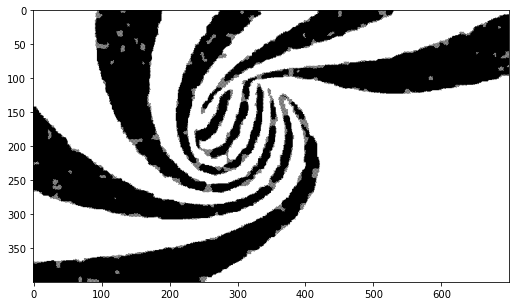

In [7]:
MCMC = IsingGibbsSamplerParams(
    y=noisy,
    a=0.1,
    b=100,
    m=0,
    s=0.5
)

np.random.seed(0)
sample = MCMC.gibbs_sampling(T=50, trajectory=False)
show(sample[0])

After investigating the influence of the hyperparameters, I found that $a$ needed to be small (which is consistent with the fact we do not want too much bias toward one pixel value), that $b$ needed to be large (which is consistent with the fact that we should rely heavily on neighbouring values to denoise the image).